In [2]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2026-01-27 23:03:01.815596: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-27 23:03:01.912484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-27 23:03:01.912523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-27 23:03:01.924661: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-27 23:03:01.952948: I tensorflow/core/platform/cpu_feature_guar

In [5]:
# %matplotlib inline
# mpl.pyplot.style.use('default')
# mpl.pyplot.close('all')

# font, rcnew = plot_utils.matplotlib_default_config()
# mpl.rc('font', **font)
# mpl.pyplot.rcParams.update(rcnew)
# mpl.pyplot.style.use('tableau-colorblind10')
# %config InlineBackend.figure_format = 'retina'

# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12

# test on single

In [6]:
tag_params = '_p5_n10000'
idx_LH = 0

# change this directory path as needed
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib{tag_params}'
subdir_prefix = 'LH'
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
bias_terms_eul = np.load(fn_fields)


In [13]:
#the order is b1, b2, bs2, blaplacian
#bias_params = [1, 0, 0, 0]
bias_params = [1.2, 0.5, 0.25, 5]

# use 512 for normalization, because this is the original resolution of the mocks (they were downsampled to 128)
# this doesn't matter for visualization, but will when you go to compute statistics
n_grid_orig = 512
tracer_field = utils.get_tracer_field(bias_terms_eul, bias_params, n_grid_norm=n_grid_orig)

In [14]:
box_size = 1000 # Mpc/h
n_grid = 128 

In [15]:
params_df, param_dict_fixed = data_loader.load_cosmo_params(tag_params)
param_dict = params_df.loc[idx_LH].to_dict()
cosmo = utils.get_cosmo(param_dict)

In [16]:
matter_density_field = bias_terms_eul[1]
pgm_obj = cs.compute_pgm(tracer_field, matter_density_field, cosmo, box_size, n_grid_orig)

Computing pgm, using n_grid =  128


2026-01-22 01:07:19,584 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 6.31307e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002340 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.079373 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000131 secs
bacco.power : Deallocating arrays


2026-01-22 01:07:20,430 bacco.statistics :  ...done in 0.846 s


In [17]:
pk_obj = cs.compute_pk(tracer_field, cosmo, box_size, n_grid_orig)

Computing pk, using n_grid =  128


2026-01-22 01:07:20,835 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0


2026-01-22 01:07:21,140 bacco.statistics :  ...done in 0.305 s


bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002405 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.026766 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000135 secs
bacco.power : Deallocating arrays


/tmp/ipykernel_2026127/847835007.py:15: RuntimeWarning: invalid value encountered in divide
  frac_diff = (pk_obj['pk'] - pgm_obj['pk']) / pgm_obj['pk']


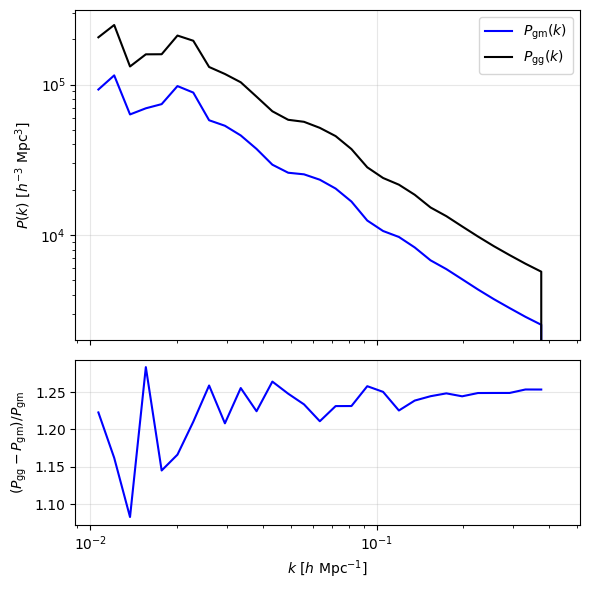

In [24]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Upper panel: power spectra
ax1.plot(pgm_obj['k'], pgm_obj['pk'], label=r'$P_{\rm gm}(k)$', color='blue')
ax1.plot(pk_obj['k'], pk_obj['pk'], label=r'$P_{\rm gg}(k)$', color='k')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lower panel: fractional difference
# Assume k bins are the same
frac_diff = (pk_obj['pk'] - pgm_obj['pk']) / pgm_obj['pk']

ax2.plot(pgm_obj['k'], frac_diff, color='blue', linewidth=1.5)
#ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.set_xscale('log')
ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$')
ax2.set_ylabel(r'$(P_{\rm gg} - P_{\rm gm}) / P_{\rm gm}$')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Load and plot

In [5]:
data_mode = 'muchisimocks'
statistics = ['pk', 'pgm']
#statistics = ['pk']

### train
# tag_params = '_p5_n10000'
# tag_biasparams = '_biaszen_p4_n10000'
# tag_noise = '_noise_unit_p5_n10000'
# tag_Anoise = '_Anmult_p5_n10000'
### test
tag_params = '_test_p5_n1000'
tag_biasparams = '_biaszen_p4_n1000'
#tag_noise = '_noise_unit_test_p5_n1000'
#tag_Anoise = '_Anmult_p5_n1000'
## cosmic variance (quijote)
# tag_params="_quijote_p0_n1000"
# tag_biasparams="_b1000_p0_n1"
# tag_noise="_noise_quijote_p0_n1000"
# tag_Anoise="_An1_p0_n1"
tag_noise = None
tag_Anoise = None
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
if tag_noise is None:
    tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
else:
    tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_noise + tag_Anoise + tag_datagen
k_arr, y_arr, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
print(y_arr[0].shape)
#print(y_arr[1].shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_test_p5_n1000
Found 1000 diff cosmo pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_test_p5_n1000


Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_pk_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000.txt
Loading from ../data/masks/mask_pk_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000.txt (already exists)
Masked 1 out of 30 bins
(29,) (1000, 29) (1000, 29)
dir_statistics: /scratch/kstoreyf/muchisimocks/data/pgms_mlib/pgms_test_p5_n1000_biaszen_p4_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pgms_mlib/pgms_test_p5_n1000_biaszen_p4_n1000
Found 1000 diff cosmo pgms in /scratch/kstoreyf/muchisimocks/data/pgms_mlib/pgms_test_p5_n1000_biaszen_p4_n1000
Loaded pgm data with shape (1000, 30)
No mask for this statistic, using all data
Masked 0 out of 30 bins
(30,) (1000, 30) (1000, 30)
(1000, 29)


In [6]:
theta, param_names = data_loader.param_dfs_to_theta(idxs_params, params_df, biasparams_df, Anoise_df=Anoise_df)

In [7]:
# unpack the stats
k_pk = k_arr[statistics.index('pk')]
y_pk = y_arr[statistics.index('pk')]

k_pgm = k_arr[statistics.index('pgm')]
y_pgm = y_arr[statistics.index('pgm')]

# k_bispec = k_arr[statistics.index('bispec')]
# y_bispec = y_arr[statistics.index('bispec')]


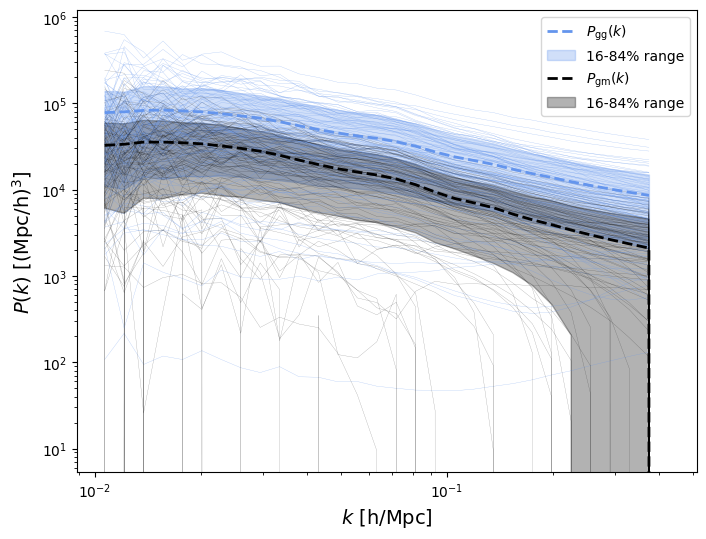

In [13]:

plt.figure(figsize=(8,6))

n_plot = np.min([100, y_pk.shape[0]])
first = True
for i in range(n_plot):
    label = None
    plt.plot(k_pk, y_pk[i], color='cornflowerblue', alpha=0.6, lw=0.2, label=label)
    plt.plot(k_pgm, y_pgm[i], color='black', alpha=0.4, lw=0.2, label=label)

mean = np.mean(y_pk, axis=0)
p16 = np.percentile(y_pk, 16, axis=0)
p84 = np.percentile(y_pk, 84, axis=0)
plt.plot(k_pk, mean, color='cornflowerblue', lw=2, ls='--', label=r'$P_{\rm gg}(k)$')
plt.fill_between(k_pk, p16, p84, color='cornflowerblue', alpha=0.3, label=r'16-84% range')

mean = np.mean(y_pgm, axis=0)
p16 = np.percentile(y_pgm, 16, axis=0)
p84 = np.percentile(y_pgm, 84, axis=0)
plt.plot(k_pgm, mean, color='black', lw=2, ls='--', label=r'$P_{\rm gm}(k)$')
plt.fill_between(k_pgm, p16, p84, color='black', alpha=0.3, label=r'16-84% range')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=10)

# inference

In [8]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = None
tag_Anoise = None
tag_reparam = '_rp'

n_train = 10000
statistics_arr = [['pgm']]
#statistics_arr = [['pk']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
if tag_noise is None:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_reparam}_ntrain{n_train}' for tag_stats in tag_stats_arr]
else:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}{tag_reparam}_ntrain{n_train}' for tag_stats in tag_stats_arr]
    
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
color_pgm = 'green'
colors = [color_pgm]

In [4]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']


## coverage

In [5]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tags_biasparams_test = ['_biaszen_p4_n1000']*len(tags_inf)
tags_noise_test = None
tags_Anoise_test = None
tags_mask_test = ['', '', '']
tag_datagen_test = ''               

n_test_eval = 100
if n_test_eval is not None:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tags_biasparams_test[i] + tag_datagen_test + f'_neval{n_test_eval}' for i in range(len(tag_stats_arr))]
else:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tags_biasparams_test[i] + tag_datagen_test for i in range(len(tag_stats_arr))]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pgm_test_p5_n1000_biaszen_p4_n1000_neval100


In [6]:
#param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
#param_names_show = utils.param_names_all_ordered
param_names_show = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1', \
                   'sigma8_cold_sq_x_b2', 'sigma8_cold_sq_x_bs2', 'sigma8_cold_x_bl']
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    print(param_names)                                                                
    # Load theta_test in original space
    theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i])
    if n_test_eval is not None:
        theta_test = theta_test[:n_test_eval]
    
    # Reparameterize theta_test if tag_reparam is set
    if tag_reparam is not None and tag_reparam != '':
        # Get original param_names for theta_test
        param_names_orig = param_names_vary.copy()
        # Reparameterize theta_test to match the reparameterized param_names from inference
        theta_test, param_names_test_reparam = utils.reparameterize_theta(theta_test, param_names_orig)
    else:
        param_names_test_reparam = param_names_vary.copy()
    
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            # Use reparameterized theta_test if applicable
            if param_name_show in param_names_test_reparam:
                idx_pn_test = list(param_names_test_reparam).index(param_name_show)
                theta_true_inf.append(theta_test[:,idx_pn_test])
            else:
                # If param_name_show is not in param_names_test_reparam, it might be a reparameterized param
                # that we need to compute from original params
                theta_true_inf.append(np.full(theta_test.shape[0], np.nan))
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pgm_p5_n10000_biaszen_p4_n200000_rp_ntrain10000/samples_test_muchisimocks_pgm_test_p5_n1000_biaszen_p4_n1000_neval100_pred.npy
['omega_cold' 'sigma8_cold' 'sigma8_cold_x_b1' 'sigma8_cold_sq_x_b2'
 'sigma8_cold_sq_x_bs2' 'sigma8_cold_x_bl']


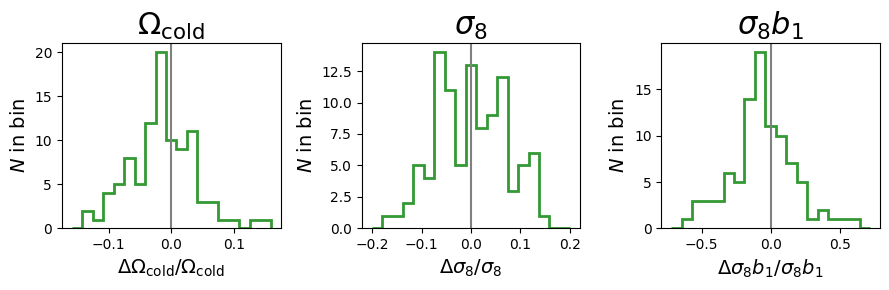

(1, 100, 6)


In [9]:
param_names_key = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1']
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, 
                        param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=False)
print(fracdiffs_arr.shape)
# for param_name in param_names_key:
#     std_fracdiffs_pk = np.std(fracdiffs_arr[0,:,param_names_show.index(param_name)])
#     std_fracdiffs_pk_bispec = np.std(fracdiffs_arr[2,:,param_names_show.index(param_name)])
#     improvement = std_fracdiffs_pk / std_fracdiffs_pk_bispec
#     print(f'{param_name}: {improvement:.3f} ({std_fracdiffs_pk:.3f} / {std_fracdiffs_pk_bispec:.3f})')
                        

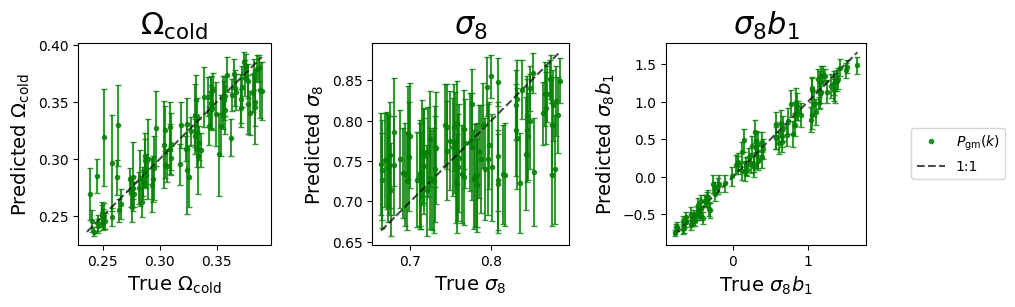

In [10]:
idx_stat = 0 # p
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

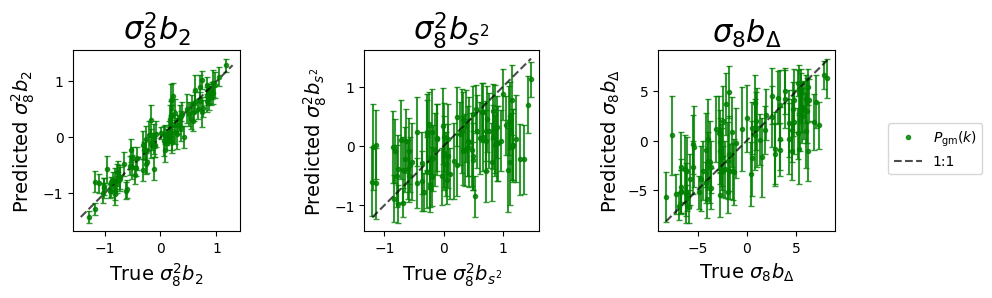

In [11]:
idx_stat = 0 # p
param_names_plot = ['sigma8_cold_sq_x_b2', 'sigma8_cold_sq_x_bs2', 'sigma8_cold_x_bl']
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_plot, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)